# [GD-03~04] CutMix, Mixup
_____

## 목차
### 1. 개요
    1.1 들어가기에 앞서
    1.2 루브릭 평가기준
 
### 2. 프로젝트: CutMix 또는 Mixup 비교실험 하기
    2.1 데이터 불러오기
    2.2 Augmentation 적용하기
    2.3 Cutmix Augmentation
    2.4 Mixup Augmentation
    2.5 모델 만들기
    2.6 모델 훈련하기
    
### 3. 결론
    3.1 회고
    
-----

## 1. 개요

### 1.1 들어가기에 앞서

#### 실습 목표

- Augmentation을 하는 이유를 알아갑니다.
- 여러 가지 Augmentation 방법을 알아둡니다.
- 학습에 Augmentation을 적용할때 주의해야 할 점을 숙지합니다.


---

### 1.2 루브릭 평가기준

평가문항|상세기준
-|-
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

---

## 2. 프로젝트: CutMix 또는 Mixup 비교실험 하기
### 2.1 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

- 필요한 라이브러리 불러오기

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- GPU 환경 체크

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


- 데이터셋 불러오기
- 데이터셋은 `stanford_dogs` 데이터셋을 사용

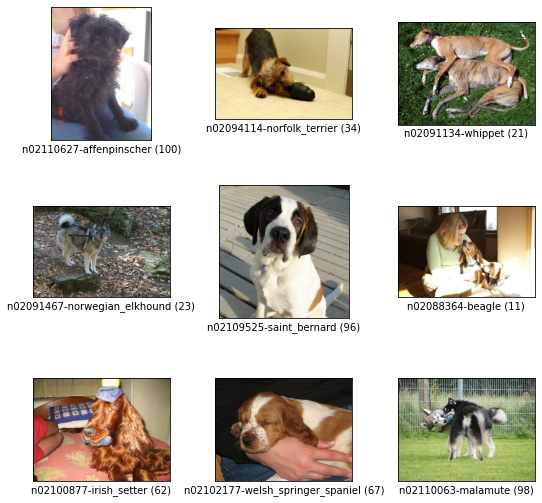

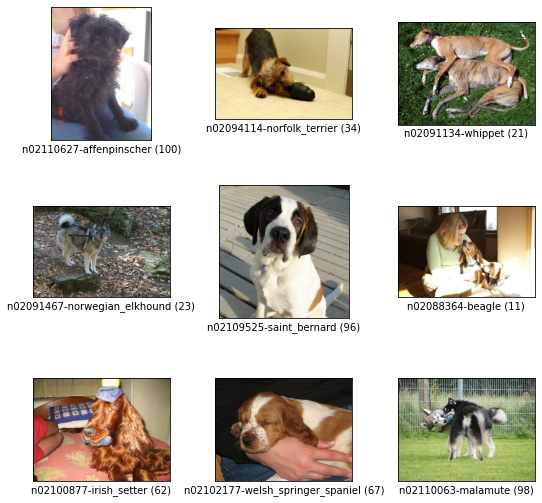

In [4]:
tfds.show_examples(ds_train, ds_info)

- 임의의 샘플 출력

---

### 2.2 Augmentation 적용하기

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- 사용될 모든 이미지에 대해 입력 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

- `random_flip_left_right()`: 이미지셋에 대해 랜덤한 확률로 좌우대칭 
- `random_brightness()`: 이미지셋에 대해 랜덤한 확률로 'brightness'를 조절하여 다양한 환경에서 얻어진 이미지에 대응

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- `apply_normalize_on_dataset`: 데이터셋을 가공하는 형태로 모든 과정을 구현한 메인함수

---

### 2.3 Cutmix Augmentation

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

- 데이터셋에서 불러온 데이터에 `apply_normalize_on_dataset()`에서 `with_aug`를 `False`로 주어 augmentation이 적용되 지 않도록 하고, 나머지 하나는 `True`로 주어 augmentation이 적용되도록 함

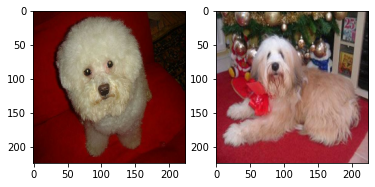

In [9]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

- 배치 내 이미지를 섞어주기 위해, 데이터셋에서 섞어줄 이미지 2개를 가져옴

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(97, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(72, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


- `get_clip_box()`: 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수  

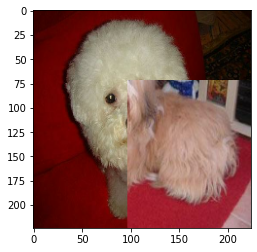

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

- `mix_2_images()`: image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

- `mix_2_labels()`: 면적에 비례해서 라벨을 섞어주는 함수

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- 위에서 구현한 두 함수 `mix_2_images()`와 `mix_2_label()`을 활용하여 배치 단위의 `cutmix()` 함수를 구현

---

### 2.4 Mixup Augmentation

In [14]:
num_classes = ds_info.features["label"].num_classes

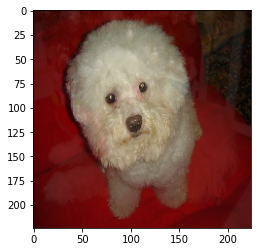

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.14301014 0.         0.
 0.         0.         0.         0.         

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞음

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- 위에서 구현한 함수를 활용해 `mixup()` 함수를 구현

In [17]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용돼야 하므로, `batch()` 함수 뒤에 CutMix가 오도록함

In [18]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

---

### 2.5 모델 만들기

In [20]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

---

### 2.6 모델 훈련하기

`sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용

In [24]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 156s 195ms/step - loss: 2.2191 - accuracy: 0.4420 - val_loss: 3.5981 - val_accuracy: 0.1795
Epoch 2/20
750/750 [==============================] - 150s 201ms/step - loss: 0.7652 - accuracy: 0.7837 - val_loss: 1.1506 - val_accuracy: 0.6638
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.2346 - accuracy: 0.9491 - val_loss: 0.9397 - val_accuracy: 0.7249
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0691 - accuracy: 0.9934 - val_loss: 0.9153 - val_accuracy: 0.7379
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0281 - accuracy: 0.9987 - val_loss: 0.9238 - val_accuracy: 0.7390
Epoch 6/20
750/750 [==============================] - 153s 203ms/step - loss: 0.0177 - accuracy: 0.9995 - val_loss: 0.9318 - val_accuracy: 0.7429
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0129 - accuracy: 0.9997 - val_loss: 0.9407 -

In [25]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 2.2644 - accuracy: 0.4271 - val_loss: 3.1945 - val_accuracy: 0.2422
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.9496 - accuracy: 0.7262 - val_loss: 1.1323 - val_accuracy: 0.6680
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.4944 - accuracy: 0.8626 - val_loss: 1.0315 - val_accuracy: 0.6945
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 0.2587 - accuracy: 0.9400 - val_loss: 1.1064 - val_accuracy: 0.6865
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 0.1472 - accuracy: 0.9718 - val_loss: 1.0037 - val_accuracy: 0.7157
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0922 - accuracy: 0.9852 - val_loss: 0.9989 - val_accuracy: 0.7240
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0501 - accuracy: 0.9933 - val_loss: 0.9936 -

In [26]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 3.8087 - accuracy: 0.2112 - val_loss: 3.0990 - val_accuracy: 0.2514
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9527 - accuracy: 0.4304 - val_loss: 1.4251 - val_accuracy: 0.6102
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.6430 - accuracy: 0.5243 - val_loss: 1.2254 - val_accuracy: 0.6502
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4420 - accuracy: 0.5925 - val_loss: 1.2831 - val_accuracy: 0.6486
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2903 - accuracy: 0.6468 - val_loss: 1.1648 - val_accuracy: 0.6774
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.1691 - accuracy: 0.6891 - val_loss: 1.1498 - val_accuracy: 0.6779
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.0722 - accuracy: 0.7097 - val_loss: 1.1599 -

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.8337 - accuracy: 0.2156 - val_loss: 3.3872 - val_accuracy: 0.2109
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9279 - accuracy: 0.4354 - val_loss: 1.3388 - val_accuracy: 0.6259
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.6282 - accuracy: 0.5391 - val_loss: 1.3758 - val_accuracy: 0.6167
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4153 - accuracy: 0.6036 - val_loss: 1.1222 - val_accuracy: 0.6851
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2813 - accuracy: 0.6451 - val_loss: 1.2411 - val_accuracy: 0.6580
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1479 - accuracy: 0.6917 - val_loss: 1.5054 - val_accuracy: 0.6025
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0602 - accuracy: 0.7194 - val_loss: 1.4426 -

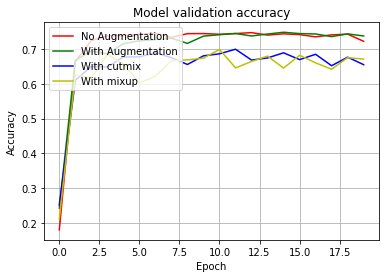

In [33]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With cutmix','With mixup'], loc='upper left')
plt.grid(True)
plt.show()

- No Augmentation과 Augmentation의 경우 accuracy가 매우 비슷했다.
- 또한 cutmix와 mixup을 적용했을 때에 accuracy가 매우 비슷했으며, 이들을 적용했을 때 오히려 accuracy가 낮아지는 것을 볼 수 있다.
- 이유에 대해 생각해보면, 이미지 쌍을 랜덤하게 뽑기때문에 정확적인 측면에서 수치가 낮아지는 것이 아닌가 생각이 든다.

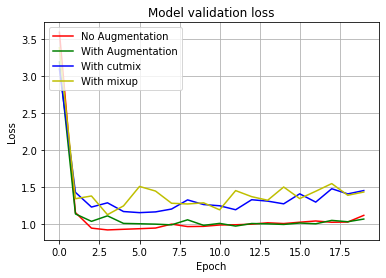

In [34]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With cutmix','With mixup'], loc='upper left')
plt.grid(True)
plt.show()

- accuracy와 마찬가지로 loss도 비슷한 흐름이다.
- cutmix와 mixup을 적용했을 때 오히려 loss가 높아지는 것을 볼 수 있었다.

---

## 3. 결론
### 3.1 회고

- 이번 고잉디퍼 노드는 전에도 지속적으로 Augmentation을 다뤘기에 비교적 수월했던 것 같다. 노드를 진행하면서 아쉬웠던 점이 있었다면, 모델훈련중에 자꾸 커널이 끊기는 상황이 발생했었다. 클라우드 기반이기 때문에 해결할 수 있는 해답을 못찾아, 끊기지 않길 빌며 모델을 훈련시켰다. 얼른 코랩 등 다른 환경에 적응할 필요를 크게 느꼈던 것 같다.

---